<a href="https://colab.research.google.com/github/YassGan/Emotion_Face_Recognition/blob/main/Emotion_Recognition_CK%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the Drive

In [1]:
from google.colab import drive
import shutil

# Mount your Google Drive
drive.mount('/content/drive')

# Define the source and destination paths
source_folder = '/content/drive/MyDrive/CK+'
destination_folder = '/content/CK+'

# Create the destination folder if it doesn't exist
try:
    shutil.copytree(source_folder, destination_folder)
    print(f"Folder copied successfully to {destination_folder}")
except FileExistsError:
    print(f"Destination folder '{destination_folder}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
Folder copied successfully to /content/CK+


# Install the necessary dependencies if not already installed

In [2]:
!pip install numpy matplotlib keras tensorflow


# Import the necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Read the images

In [4]:
import os

for dirname, _, filenames in os.walk("./CK+"):
    i=0
    dirname_str=str(dirname)
    print(dirname_str)
    dirname_str=[]
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        i+=1
        dirname_str.append(os.path.join(dirname, filename))
    print("Total number in ",dirname," is " ,i)





./CK+
Total number in  ./CK+  is  0
./CK+/sadness
Total number in  ./CK+/sadness  is  84
./CK+/fear
Total number in  ./CK+/fear  is  75
./CK+/disgust
Total number in  ./CK+/disgust  is  177
./CK+/anger
Total number in  ./CK+/anger  is  135
./CK+/surprise
Total number in  ./CK+/surprise  is  249
./CK+/contempt
Total number in  ./CK+/contempt  is  54
./CK+/happy
Total number in  ./CK+/happy  is  207


# As we can see the dataset is unbalanced, so I thought on diminishing the elements of the overrepresented classes and do a data augmentation for the underrepresented classes.

# Reread the images and store their paths in different arrays

In [5]:
import os
import random

# Initialize emotion-specific arrays
disgust_paths = []
contempt_paths = []
surprise_paths = []
anger_paths = []
happy_paths = []
sadness_paths = []
fear_paths = []

# Valid image extensions
valid_extensions = (".jpg", ".jpeg", ".png")

# Traverse directory and collect paths
for dirname, _, filenames in os.walk("./CK+"):
    for filename in filenames:
        if filename.lower().endswith(valid_extensions):
            full_path = os.path.join(dirname, filename)
            if "disgust" in dirname:
                disgust_paths.append(full_path)
            elif "contempt" in dirname:
                contempt_paths.append(full_path)
            elif "surprise" in dirname:
                surprise_paths.append(full_path)
            elif "anger" in dirname:
                anger_paths.append(full_path)
            elif "happy" in dirname:
                happy_paths.append(full_path)
            elif "sadness" in dirname:
                sadness_paths.append(full_path)
            elif "fear" in dirname:
                fear_paths.append(full_path)

# Calculate average number of images per category
avg_number = round((len(disgust_paths) + len(contempt_paths) + len(surprise_paths) +
                    len(anger_paths) + len(happy_paths) + len(sadness_paths) + len(fear_paths)) / 7)
print("The average number between all the classes is", avg_number)

# Limit the arrays to avg_number randomly
if len(disgust_paths) > avg_number:
    disgust_paths = random.sample(disgust_paths, avg_number)
if len(contempt_paths) > avg_number:
    contempt_paths = random.sample(contempt_paths, avg_number)
if len(surprise_paths) > avg_number:
    surprise_paths = random.sample(surprise_paths, avg_number)
if len(anger_paths) > avg_number:
    anger_paths = random.sample(anger_paths, avg_number)
if len(happy_paths) > avg_number:
    happy_paths = random.sample(happy_paths, avg_number)
if len(sadness_paths) > avg_number:
    sadness_paths = random.sample(sadness_paths, avg_number)
if len(fear_paths) > avg_number:
    fear_paths = random.sample(fear_paths, avg_number)

# Output results
print("Balanced dataset sizes by diminishing randomly the overrepresented classes:")
print("Disgust:", len(disgust_paths))
print("Contempt:", len(contempt_paths))
print("Surprise:", len(surprise_paths))
print("Anger:", len(anger_paths))
print("Happy:", len(happy_paths))
print("Sadness:", len(sadness_paths))
print("Fear:", len(fear_paths))


The average number between all the classes is 140
Balanced dataset sizes by diminishing randomly the overrepresented classes:
Disgust: 140
Contempt: 54
Surprise: 140
Anger: 135
Happy: 140
Sadness: 84
Fear: 75


# Reading and preprocessing images

In [6]:
import tensorflow as tf
import numpy as np

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, image_size=(48, 48)):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image (this automatically handles formats like PNG, JPEG)
    image = tf.image.decode_image(image, channels=3)  # Decode as RGB
    # Set the shape of the image explicitly
    image.set_shape([None, None, 3])  # Setting the shape explicitly helps tf.image.resize
    # Resize the image
    image = tf.image.resize(image, image_size)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image

# Function to create a batched dataset for a given class
def create_dataset(image_paths, batch_size=20, image_size=(48, 48)):
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(lambda x: load_and_preprocess_image(x, image_size))
    return image_dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to generate augmented images
def generate_augmented_images(image_dataset, num_images_needed, batch_size=20, image_size=(48, 48)):

    # Convert the dataset to a NumPy array
    images = []
    for image in image_dataset:
        images.append(image.numpy())  # Convert to NumPy array
    images = np.array(images)

    # Define the augmentation strategy
    datagen = ImageDataGenerator(
        rotation_range=12,  # Rotation up to 15 degrees
        width_shift_range=0.11,  # Horizontal translation (10% of the image)
        height_shift_range=0.1,  # Vertical translation (10% of the image)
        zoom_range=0.2,  # Zoom up to 10%
        horizontal_flip=False,  # No horizontal flip
        fill_mode='nearest'  # Fill mode for transformed areas
    )
    # Fit the datagen to the images
    datagen.fit(images)

    ## If the required number of images to add is lower then the batch size
    if num_images_needed < batch_size:
        batch_size = num_images_needed

    augmented_images = []
    batches_needed = num_images_needed // batch_size

    # Generate the required number of augmented images
    for _ in range(batches_needed):
        augmented_batch = next(datagen.flow(images, batch_size=batch_size))
        augmented_images.append(augmented_batch)

    # Concatenate the augmented images
    augmented_images = np.concatenate(augmented_images, axis=0)

    # If there are any remaining images (less than a full batch), generate one more batch
    remaining_images = num_images_needed % batch_size
    if remaining_images > 0:
        augmented_batch = next(datagen.flow(images, batch_size=remaining_images))
        augmented_images = np.concatenate([augmented_images, augmented_batch], axis=0)

    return augmented_images




def augmented_new_dataset(dataset):
  # Get the number of images (length of the dataset)
  numb_origninal_contempt_images = len(list(dataset.as_numpy_iterator()))

  if numb_origninal_contempt_images < avg_number:
      difference_contempt=avg_number-numb_origninal_contempt_images
      # Generate augmented images
      augmented_images = generate_augmented_images(dataset, num_images_needed=difference_contempt, batch_size=20, image_size=(48, 48))

      # Load the original dataset and convert it to NumPy
      original_images = []
      for image in dataset:
          original_images.append(image.numpy())
      original_images = np.array(original_images)

      # Concatenate original and augmented images
      combined_images = np.concatenate([original_images, augmented_images], axis=0)


      # Convert the combined NumPy array back to a TensorFlow Dataset
      combined_tf_dataset = tf.data.Dataset.from_tensor_slices(combined_images)

      # Optionally, batch and shuffle the TensorFlow Dataset
      combined_tf_dataset = combined_tf_dataset.shuffle(buffer_size=1000)

      return combined_tf_dataset
  else :
    return dataset


fear_dataset = create_dataset(fear_paths)
final_fear_augmented_dataset =augmented_new_dataset(fear_dataset)
print(f"Fear dataset size: {len(list(final_fear_augmented_dataset.as_numpy_iterator()))}")


sadness_dataset = create_dataset(sadness_paths)
final_sadness_augmented_dataset =augmented_new_dataset(sadness_dataset)
print(f"Sadness dataset size: {len(list(final_sadness_augmented_dataset.as_numpy_iterator()))}")


happy_dataset = create_dataset(happy_paths)
final_happy_augmented_dataset =augmented_new_dataset(happy_dataset)
print(f"Happy dataset size: {len(list(final_happy_augmented_dataset.as_numpy_iterator()))}")


anger_dataset = create_dataset(anger_paths)
final_anger_augmented_dataset =augmented_new_dataset(anger_dataset)
print(f"Anger dataset size: {len(list(final_anger_augmented_dataset.as_numpy_iterator()))}")


surprise_dataset = create_dataset(surprise_paths)
final_surprise_augmented_dataset =augmented_new_dataset(surprise_dataset)
print(f"Surprise dataset size: {len(list(final_surprise_augmented_dataset.as_numpy_iterator()))}")


contempt_dataset = create_dataset(contempt_paths)
final_contempt_augmented_dataset =augmented_new_dataset(contempt_dataset)
print(f"Contempt dataset size: {len(list(final_contempt_augmented_dataset.as_numpy_iterator()))}")


disgust_dataset = create_dataset(disgust_paths)
final_disgust_augmented_dataset =augmented_new_dataset(disgust_dataset)
print(f"Disgust dataset size: {len(list(final_disgust_augmented_dataset.as_numpy_iterator()))}")




Fear dataset size: 140
Sadness dataset size: 140
Happy dataset size: 140
Anger dataset size: 140
Surprise dataset size: 140
Contempt dataset size: 140
Disgust dataset size: 140


# Function that displays an image

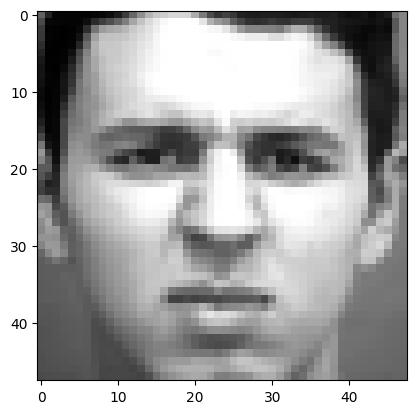

In [7]:
def get_image_from_dataset(dataset, index=0):
    iterator = dataset.as_numpy_iterator()

    for i, item in enumerate(iterator):
        if i == index:
            plt.figure()

            # Check if the item is a tuple (image, label) or just the image
            if isinstance(item, tuple):
                image, label = item  # Unpack if it's a tuple
                plt.title(f"Label: {label}")  # Display label if available
            else:
                image = item  # Otherwise, it's just the image

            plt.imshow(image)
            plt.show()
            break  # Exit the loop once the image is displayed

##Example display the image with the index 1 in the disgusted dataset
get_image_from_dataset(final_disgust_augmented_dataset,1)

# Prepare Data for Model Training



Train dataset size: 686
Validation dataset size: 189
Test dataset size: 105
len(list(dataset.as_numpy_iterator()))  686


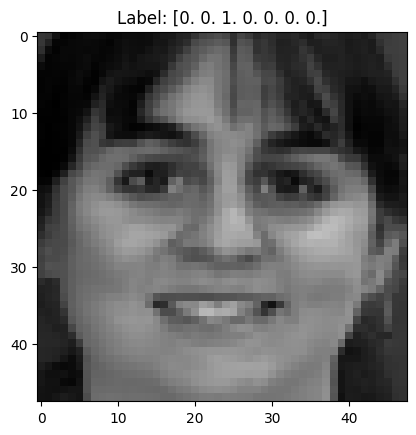

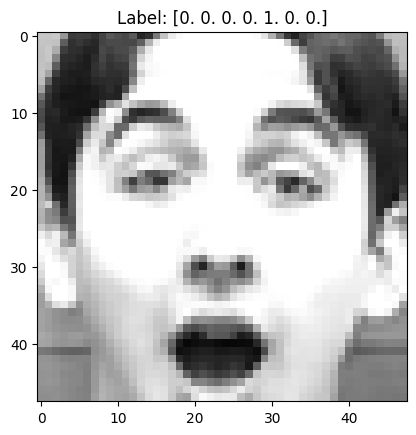

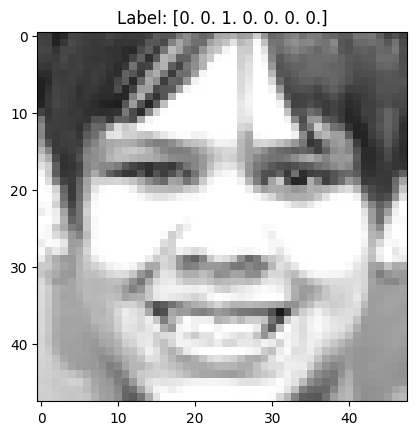

Train dataset size: 35
Validation dataset size: 10
Test dataset size: 6


In [8]:
BATCH_SIZE=20


# Combine Datasets and Create Labels
all_datasets = [
    (final_fear_augmented_dataset, 0),   # 0: fear
    (final_sadness_augmented_dataset, 1),  # 1: sadness
    (final_happy_augmented_dataset, 2),   # 2: happy
    (final_anger_augmented_dataset, 3),   # 3: anger
    (final_surprise_augmented_dataset, 4),# 4: surprise
    (final_contempt_augmented_dataset, 5),# 5: contempt
    (final_disgust_augmented_dataset, 6)  # 6: disgust
]


# Function to create a labeled dataset
def create_labeled_dataset(dataset, label):
    labeled_dataset = dataset.map(lambda image: (image, tf.one_hot(label, depth=7)))  # One-hot encode the labels
    return labeled_dataset

# Create labeled datasets
labeled_datasets = [create_labeled_dataset(ds, label) for ds, label in all_datasets]


"""# Split data into training, validation and testing and concatenating them in a good tilted balanced way so the program doesn't get biased"""
# Split data into training and validation
def split_dataset(dataset, train_split=0.7, val_split=0.2, test_split=0.1):
    dataset_size = dataset.cardinality().numpy()

    if dataset_size == tf.data.UNKNOWN_CARDINALITY:
        print("Cannot determine dataset size, ensure it has a defined cardinality, such as using a batched dataset.")
        return None, None, None

    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * (train_split + val_split))

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size-train_size)
    test_dataset = dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset


train_dataset_fear, val_dataset_fear, test_dataset_fear = split_dataset(labeled_datasets[0])
train_dataset_sadness, val_dataset_sadness, test_dataset_sadness = split_dataset(labeled_datasets[1])
train_dataset_happy, val_dataset_happy, test_dataset_happy = split_dataset(labeled_datasets[2])
train_dataset_anger, val_dataset_anger, test_dataset_anger = split_dataset(labeled_datasets[3])
train_dataset_surprise, val_dataset_surprise, test_dataset_surprise = split_dataset(labeled_datasets[4])
train_dataset_contempt, val_dataset_contempt, test_dataset_contempt = split_dataset(labeled_datasets[5])
train_dataset_disgust, val_dataset_disgust, test_dataset_disgust = split_dataset(labeled_datasets[6])


# Concatenate the training sets
train_dataset = train_dataset_fear.concatenate(train_dataset_sadness)
train_dataset = train_dataset.concatenate(train_dataset_happy)
train_dataset = train_dataset.concatenate(train_dataset_anger)
train_dataset = train_dataset.concatenate(train_dataset_surprise)
train_dataset = train_dataset.concatenate(train_dataset_contempt)
train_dataset = train_dataset.concatenate(train_dataset_disgust)

# Concatenate the validation sets
val_dataset = val_dataset_fear.concatenate(val_dataset_sadness)
val_dataset = val_dataset.concatenate(val_dataset_happy)
val_dataset = val_dataset.concatenate(val_dataset_anger)
val_dataset = val_dataset.concatenate(val_dataset_surprise)
val_dataset = val_dataset.concatenate(val_dataset_contempt)
val_dataset = val_dataset.concatenate(val_dataset_disgust)


# Concatenate the testing sets
test_dataset = test_dataset_fear.concatenate(test_dataset_sadness)
test_dataset = test_dataset.concatenate(test_dataset_happy)
test_dataset = test_dataset.concatenate(test_dataset_anger)
test_dataset = test_dataset.concatenate(test_dataset_surprise)
test_dataset = test_dataset.concatenate(test_dataset_contempt)
test_dataset = test_dataset.concatenate(test_dataset_disgust)


# Shuffle the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.shuffle(buffer_size=1000)



print(f"Train dataset size: {len(list(train_dataset.as_numpy_iterator()))}")
print(f"Validation dataset size: {len(list(val_dataset.as_numpy_iterator()))}")
print(f"Test dataset size: {len(list(test_dataset.as_numpy_iterator()))}")


print("len(list(dataset.as_numpy_iterator())) ",len(list(train_dataset.as_numpy_iterator())))


get_image_from_dataset(train_dataset,1)

get_image_from_dataset(val_dataset,1)

get_image_from_dataset(test_dataset,1)


# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(f"Train dataset size: {len(list(train_dataset.as_numpy_iterator()))}")
print(f"Validation dataset size: {len(list(val_dataset.as_numpy_iterator()))}")
print(f"Test dataset size: {len(list(test_dataset.as_numpy_iterator()))}")






# Build the model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the improved model
model = Sequential()

# Bloc 1
model.add(Conv2D(32, kernel_size=(7, 7), input_shape=(48, 48, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(BatchNormalization())  # Ajout de la normalisation pour stabiliser l'entraînement
model.add(Conv2D(32, kernel_size=(7, 7), activation='relu', strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Légère régularisation pour éviter l'overfitting

# Bloc 2
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.19))

# Bloc 3 (New Block)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.17))



# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Normalisation avant Dropout
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher la structure du modèle
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,023,271 (3.90 MB)

 Trainable params: 1,022,119 (3.90 MB)

 Non-trainable params: 1,152 (4.50 KB)

None


# Define callbacks and train the model

In [10]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto',    restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=20,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 318ms/step - accuracy: 0.2615 - loss: 2.5675 - val_accuracy: 0.1376 - val_loss: 2.4757
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4733 - loss: 1.5444 - val_accuracy: 0.1905 - val_loss: 2.1274
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6208 - loss: 1.0734 - val_accuracy: 0.1640 - val_loss: 2.6272
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6587 - loss: 0.8929 - val_accuracy: 0.1587 - val_loss: 3.4265
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6891 - loss: 0.7947 - val_accuracy: 0.2487 - val_loss: 2.2315
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7725 - loss: 0.5990 - val_accuracy: 0.2698 - val_loss: 2.8579
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8474 - loss: 0.4548 - val_accuracy: 0.5026 - val_loss: 1.5028
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8666 - loss: 0.3819 - val_accuracy: 0.3810 -

# Afficher les courbes


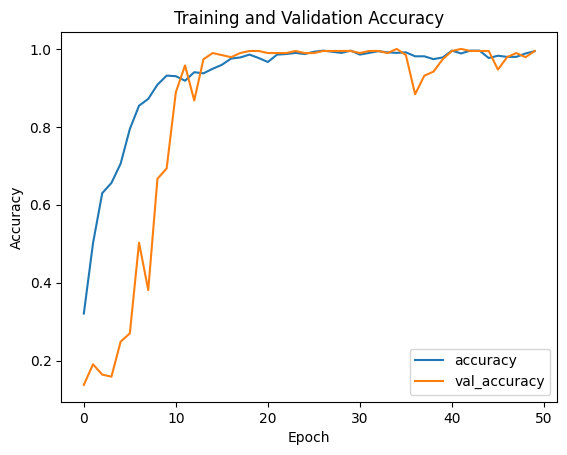

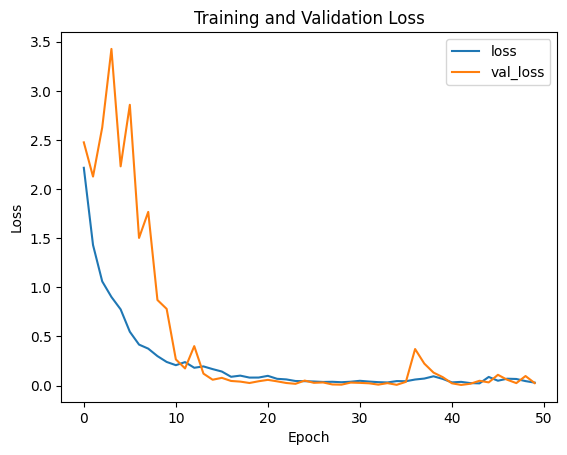

In [11]:
# Afficher les courbes d'accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Afficher les courbes de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


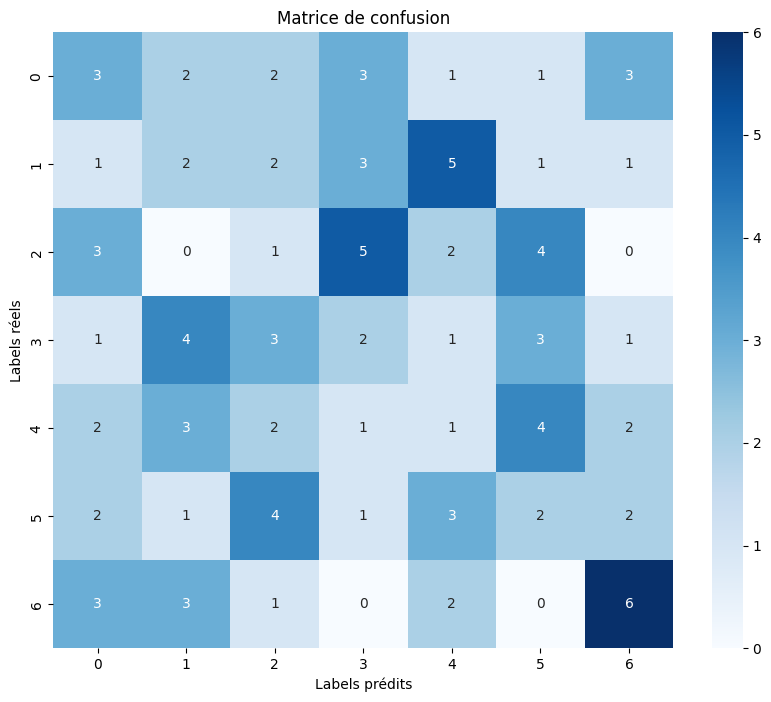

Precision: 0.16
Recall: 0.16
F1-score: 0.16
              precision    recall  f1-score   support

       anger       0.20      0.20      0.20        15
    contempt       0.13      0.13      0.13        15
     disgust       0.07      0.07      0.07        15
        fear       0.13      0.13      0.13        15
       happy       0.07      0.07      0.07        15
     sadness       0.13      0.13      0.13        15
    surprise       0.40      0.40      0.40        15

    accuracy                           0.16       105
   macro avg       0.16      0.16      0.16       105
weighted avg       0.16      0.16      0.16       105



In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Obtenir les prédictions du modèle sur l'ensemble de test
predictions = model.predict(test_dataset)


# Obtenir les labels prédits
predicted_labels = np.argmax(predictions, axis=1)



# Extract the true labels from the test dataset
test_labels = []
for batch in test_dataset:
    # Assuming your dataset structure is (images, labels)
    labels = batch[1].numpy()
    test_labels.extend(np.argmax(labels, axis=1))



# Calculer la matrice de confusion
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Labels prédits')
plt.ylabel('Labels réels')
plt.show()




from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1-score: {f1:.2f}")

# Calculate precision, recall, F1-score for each class (and other metrics)
print(classification_report(test_labels, predicted_labels, target_names=class_labels))









#Afficher une prédiction et son état réel

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


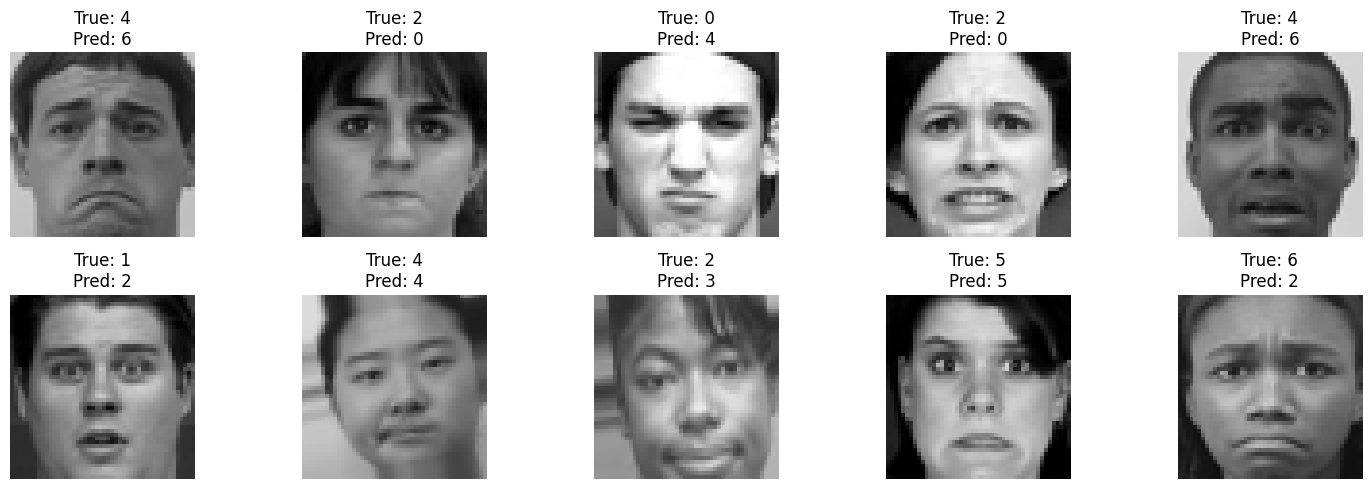

In [22]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Obtenir les prédictions du modèle sur l'ensemble de test
predictions = model.predict(test_dataset)


# Obtenir les labels prédits
predicted_labels = np.argmax(predictions, axis=1)






# Extract the true images from the test dataset
predicted_images = []
for batch in test_dataset:
    # Assuming your dataset structure is (images, labels)
    images = batch[0].numpy()
    predicted_images.extend(images)

# Extract the true labels from the test dataset
test_labels = []
for batch in test_dataset:
    # Assuming your dataset structure is (images, labels)
    labels = batch[1].numpy()
    test_labels.extend(np.argmax(labels, axis=1))



# Sélectionner un sous-ensemble d'images pour l'affichage (par exemple, 10 images)
num_images_to_display = 10
indices_to_display = np.random.choice(len(predicted_images), num_images_to_display, replace=False)
images_to_display = [predicted_images[i] for i in indices_to_display]
labels_to_display = [test_labels[i] for i in indices_to_display]
predicted_labels_to_display = [predicted_labels[i] for i in indices_to_display]


plt.figure(figsize=(15, 5))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i+1)
    plt.imshow(images_to_display[i].reshape(48, 48, 3))
    plt.title(f"True: {labels_to_display[i]}\nPred: {predicted_labels_to_display[i]}") # Changed this line
    plt.axis('off')
plt.tight_layout()
plt.show()








# Installing Gradio for GUI interactions

In [14]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [23]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# Charger le modèle sauvegardé
model = load_model('best_model.keras')

# Classe des labels (Fashion MNIST)
class_labels = [
    "anger","contempt","disgust","fear","happy","sadness","surprise"
]

# Fonction pour la prédiction
def predict_emotion(image):
    # Redimensionner l'image en 48x48 et convertir en niveaux de gris
    image = image.resize((48, 48))
    image = img_to_array(image) / 255.0  # Normalisation
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch

    # Prédire avec le modèle
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]

    # Retourner le label prédit et sa confiance
    return f"Prédiction : {class_labels[predicted_class]} (Confiance : {confidence:.2f})"

# Interface Gradio
interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="pil", label="Image (48x48 en niveaux de gris)"),
    outputs=gr.Textbox(label="Résultat"),
    title="Emotion Classifier",
    description="Chargez une image d'un visage ou dessinez-le, et recevez une prédiction du modèle Emotion Recognition CK+."
)

# Lancer l'interface
interface.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2ec31629de897c9751.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2ec31629de897c9751.gradio.live


# Using a pretrained model "imagenet" instead of starting with CNN from scratch




In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

IMAGE_SIZE = (48, 48)
NUM_CLASSES = 7

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


# freeze some of the later layers
for layer in base_model.layers:
    layer.trainable = False



# Create a new model on top of the pre-trained model
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(GlobalAveragePooling2D())
pre_trained_model.add(Dense(128, activation='relu'))
pre_trained_model.add(BatchNormalization())
pre_trained_model.add(Dropout(0.5))
pre_trained_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
pre_trained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='pre_best_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
pretrained_model_history = pre_trained_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')




Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.2419 - loss: 2.3108 - val_accuracy: 0.3280 - val_loss: 1.6908
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4997 - loss: 1.4189 - val_accuracy: 0.4550 - val_loss: 1.5065
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5435 - loss: 1.2497 - val_accuracy: 0.5926 - val_loss: 1.3725
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5992 - loss: 1.0960 - val_accuracy: 0.7354 - val_loss: 1.1855
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6464 - loss: 0.9671 - val_accuracy: 0.7778 - val_loss: 1.0602
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6861 - loss: 0.8587 - val_accuracy: 0.7513 - val_loss: 0.9482
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7359 - loss: 0.7551 - val_accuracy: 0.8201 - val_loss: 0.8495
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7295 - loss: 0.7688 - val_accuracy: 0.8095 -

In [26]:

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1-score: {f1:.2f}")

# Calculate precision, recall, F1-score for each class (and other metrics)
print(classification_report(test_labels, predicted_labels, target_names=class_labels))



Precision: 0.18
Recall: 0.18
F1-score: 0.18
              precision    recall  f1-score   support

       anger       0.13      0.13      0.13        15
    contempt       0.19      0.20      0.19        15
     disgust       0.07      0.07      0.07        15
        fear       0.20      0.20      0.20        15
       happy       0.33      0.33      0.33        15
     sadness       0.36      0.33      0.34        15
    surprise       0.00      0.00      0.00        15

    accuracy                           0.18       105
   macro avg       0.18      0.18      0.18       105
weighted avg       0.18      0.18      0.18       105

